# BE 521: Homework 3 Questions

Spring 2024

68 points

Due: Feb 15th, 2024

Objective: Extract features from data and build a simple detector

## 1. Features and Simulations (39 pts)
As you learned in class, features are the backbone of almost all detection strategies, from seizures in EEG to faces in images. Features are usually defined in journal articles as an equation or set of equations, and the
task for the reader - if she wants to use that feature - is to implement that feature in code. In this section, you will explore and implement some features commonly used in EEG analysis and test them on simulated time-series data.

In [38]:
#Set up the notebook environment
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
import datetime
import time

  Cloning https://github.com/ieeg-portal/ieegpy.git to /tmp/pip-req-build-pui3gpwv
  Running command git clone --filter=blob:none --quiet https://github.com/ieeg-portal/ieegpy.git /tmp/pip-req-build-pui3gpwv
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb
  Preparing metadata (setup.py) ... done


### 1
Consider the following toy signal: 7 seconds of a 2 Hz sine wave with a quarter period phase-shift, sampled at 100 Hz.

####1a
Plot the signal (2 pts)

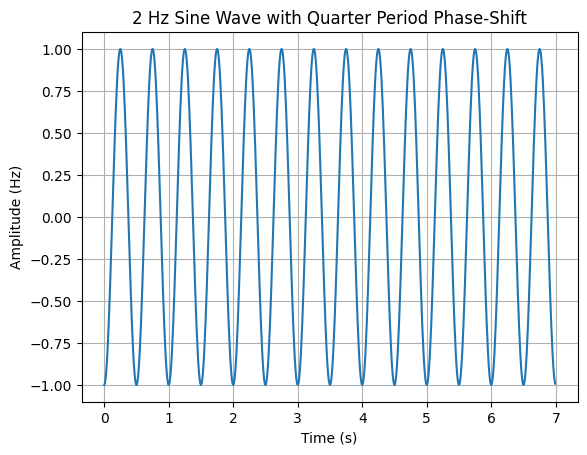

In [39]:
# My code here
duration = 7
wave_freq = 2
sample_freq = 100
phase_shift = np.pi / 2
total_freq = duration * sample_freq
time = np.linspace(0, duration, total_freq, endpoint = False)

# Signal Array
sine_array = np.sin(2 * np.pi * wave_freq * time - phase_shift)
# print(len(sine_array))

plt.plot(time, sine_array)
plt.title("2 Hz Sine Wave with Quarter Period Phase-Shift")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (Hz)")
plt.grid(True)
plt.show()

####1b
Create a function for the line-length feature $LL(x) = \sum_{i=1}^n |x_i - x_{i - 1}|$. This function can be implemented as a (cheeky) one-liner using Numpy. You may find [`np.ediff1d`](https://numpy.org/doc/stable/reference/generated/numpy.ediff1d.html), [`np.sum`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html), and [`np.absolute`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) to be helpful. (4 pts)

In [40]:
#your code here

### x: Signal Array
'''def line_length(x):

  diff_x = np.ediff1d(x)
  abs_diff_x = np.absolute(diff_x)
  sum_abs_diff_x = np.sum(abs_diff_x)

  return sum_abs_diff_x'''

def line_length(x): return np.sum(np.absolute(np.ediff1d(x)))

####1c
What is the line length of this signal? (2 pts)

In [41]:
# My code here

# Calculate line length
signal_length = line_length(sine_array)
print("The line length of this signal:", signal_length)

The line length of this signal: 55.99211470131448


**My Answer Here:**

The line length of this signal: **55.99211470131448**

### 2
Consider line length of the signal using a sliding window with a certain amount of window overlap (or, to think of it another way, displacement with each "slide"). Now, instead of having just one value for the line length, you will have a number of values.

#### 2a
Given a signal `x` with sampling frequency `fs` and windows of length `winLen` and displacement `winDisp` (both in seconds), create a function called `NumWins` that calculates the number of possible (full) windows in your signal of length `xLen` (in samples). You may assume that `winDisp` is a factor of both `winLen` and the length (in seconds) of `x`. (4 pts)

In [42]:
# My code here
def NumWins(x, xLen, fs, winLen, winDisp):

  ### winLen and winDisp are both in seconds
  total_winLen = winLen * fs
  total_winDisp = winDisp * fs

  xLen = len(x)

  ### Full windows: exclude decimal part
  Num_Wins = (xLen - total_winLen) // total_winDisp + 1

  return Num_Wins

#### 2b
Use this function to calculate the number of windows for the signal described in Question 1.1 for a 400ms window with 200ms displacement. (1 pts)

In [43]:
# My code here
winLen_sec = 400 / 10**3
winDisp_sec_2b = 200 / 10**3
Num_Wins_2b = NumWins(sine_array, len(sine_array), sample_freq, winLen_sec, winDisp_sec_2b)

print("The number of windows for the signal with a 400ms window with 200ms displacement :", Num_Wins_2b)

The number of windows for the signal with a 400ms window with 200ms displacement : 34.0


**My Answer Here:**

The number of windows for the signal with a 400ms window with 200ms displacement: **34.0**

####2c
Repeat the above calculation for 50 ms window displacement. (1 pt)

In [44]:
# My code here
winDisp_sec_2c = 50 / 10**3
Num_Wins_2c = NumWins(sine_array, len(sine_array), sample_freq, winLen_sec, winDisp_sec_2c)

print("The number of windows for the signal with a 400ms window with 50ms displacement :", Num_Wins_2c)

The number of windows for the signal with a 400ms window with 50ms displacement : 133.0


**My Answer Here:**

The number of windows for the signal with a 400ms window with 50ms displacement : **133.0**

####2d
Repeat the above calculation for 100 ms window displacement. (1 pts)

In [45]:
# My code here
winDisp_sec_2d = 100 / 10**3
Num_Wins_2d = NumWins(sine_array, len(sine_array), sample_freq, winLen_sec, winDisp_sec_2d)

print("The number of windows for the signal with a 400ms window with 50ms displacement :", Num_Wins_2d)

The number of windows for the signal with a 400ms window with 50ms displacement : 67.0


**My Answer Here:**

The number of windows for the signal with a 400ms window with 100ms displacement : **67.0**

### 3

####3a
Create a function called `MovingWinFeats(x, fs, winLen, winDisp, featFn)` that returns a vector of the values of the feature on the signal `x` in all possible windows, where `featFn` is a feature function like the one you wrote in Question 1.1.b. You may find it useful to use your `NumWins` function. You may assume that the product of `winDisp` and the sampling rate `fs` is an integer. (6 pts)

In [46]:
# My code here
def MovingWinFeats(x, fs, winLen, winDisp, featFn):

  featFn_List = []

  Num_Wins = NumWins(x, len(x), fs, winLen, winDisp);

  i = 0

  # Iterate over each window
  # for i in range(Num_Wins):
  while (i < int(Num_Wins)):

    ### start position before the first displacement
    start_index = int(i * winDisp * fs)

    ### Eaccg displacement after the first displacement
    end_index = int(start_index + winLen * fs)

    # Extract current window of the signal
    window_signal = x[start_index:end_index]

    # Calculate feature value for the current window
    feat_value = featFn(window_signal)

    # Append feature value to the vector
    featFn_List.append(feat_value)

    i = i + 1

  return featFn_List

####3b
Using the signal you defined in Question 1.1 and the function you created in Question 1.1.b, calculate the line-length over windows of length 400 ms and displacement 200 ms. (2 pts)

In [47]:
# My code here
featFn = line_length(sine_array)
winDisp_sec_3b = 200 / 10**3
MovingWinFeats_3b = MovingWinFeats(sine_array, sample_freq, winLen_sec, winDisp_sec_3b, line_length)

# print(sum(MovingWinFeats_3b))
print("The line-length over windows of length 400 ms and displacement 200 ms: \n\n", MovingWinFeats_3b)

The line-length over windows of length 400 ms and displacement 200 ms: 

 [3.1873813145857244, 2.7652037140599792, 2.814676325581189, 3.301131695689426, 3.5379856217963574, 3.187381314585725, 2.765203714059979, 2.814676325581191, 3.3011316956894277, 3.5379856217963592, 3.1873813145857226, 2.7652037140599757, 2.814676325581191, 3.3011316956894277, 3.5379856217963592, 3.187381314585722, 2.7652037140599792, 2.814676325581191, 3.301131695689428, 3.5379856217963632, 3.187381314585714, 2.7652037140599792, 2.814676325581184, 3.301131695689422, 3.5379856217963637, 3.187381314585721, 2.7652037140599792, 2.814676325581184, 3.3011316956894237, 3.5379856217963637, 3.1873813145857346, 2.7652037140599752, 2.814676325581184, 3.301131695689424]


**My Answer Here:**

**The line-length over windows of length 400 ms and displacement 200 ms:**

 [3.1873813145857244, 2.7652037140599783, 2.81467632558119, 3.3011316956894254, 3.5379856217963583, 3.1873813145857257, 2.765203714059981, 2.8146763255811886, 3.301131695689424, 3.537985621796359, 3.187381314585726, 2.76520371405998, 2.814676325581189, 3.301131695689425, 3.537985621796359, 3.1873813145857253, 2.7652037140599806, 2.814676325581189, 3.3011316956894254, 3.5379856217963646, 3.1873813145857177, 2.76520371405998, 2.8146763255811824, 3.301131695689419, 3.5379856217963592, 3.187381314585711, 2.765203714059971, 2.8146763255811895, 3.3011316956894325, 3.5379856217963632, 3.187381314585724, 2.7652037140599717, 2.814676325581189, 3.3011316956894334]

#### 3c
Add a unit-amplitude 10 Hz signal (in the form of a sine wave) to your original signal and again calculate the line length over the same window and displacement. (2 pts)

In [48]:
# My code here
duration = 7
wave_freq_new = 10
sample_freq = 100
phase_shift = np.pi / 2
update_freq = duration * sample_freq
# time2 = np.linspace(0, duration, update_freq, endpoint = False)

# Update Signal Array (Add a unit-amplitude 10 Hz signal)
update_sine_array = sine_array + np.sin(2 * np.pi * wave_freq_new * time)
# print(update_sine_array)

winDisp_sec_3c = 200 / 10**3
MovingWinFeats_3c = MovingWinFeats(update_sine_array, sample_freq, winLen_sec, winDisp_sec_3c, line_length)

# print(sum(MovingWinFeats_3b))
print("Add a unit-amplitude 10 Hz signal, the line-length over the same window and displacement: \n\n", MovingWinFeats_3c)

Add a unit-amplitude 10 Hz signal, the line-length over the same window and displacement: 

 [15.389002519702535, 15.153172831546872, 15.226791222450341, 15.343503851927121, 15.284234849153234, 15.389002519702549, 15.153172831546886, 15.226791222450315, 15.343503851927117, 15.284234849153231, 15.389002519702537, 15.153172831546867, 15.226791222450318, 15.343503851927073, 15.28423484915316, 15.389002519702517, 15.153172831546875, 15.226791222450387, 15.343503851927181, 15.284234849153254, 15.38900251970245, 15.153172831546813, 15.226791222450355, 15.343503851927137, 15.284234849153265, 15.389002519702553, 15.153172831546842, 15.226791222450291, 15.343503851927078, 15.284234849153249, 15.389002519702622, 15.153172831546877, 15.226791222450334, 15.343503851927117]


**My Answer Here:**

**Add a unit-amplitude 10 Hz signal, the line-length over the same window and displacement:**

 [15.389002519702535, 15.153172831546872, 15.226791222450341, 15.343503851927121, 15.284234849153234, 15.389002519702549, 15.153172831546886, 15.226791222450315, 15.343503851927117, 15.284234849153231, 15.389002519702537, 15.153172831546867, 15.226791222450318, 15.343503851927073, 15.28423484915316, 15.389002519702517, 15.153172831546875, 15.226791222450387, 15.343503851927181, 15.284234849153254, 15.38900251970245, 15.153172831546813, 15.226791222450355, 15.343503851927137, 15.284234849153265, 15.389002519702553, 15.153172831546842, 15.226791222450291, 15.343503851927078, 15.284234849153249, 15.389002519702622, 15.153172831546877, 15.226791222450334, 15.343503851927117]

### 4
Code the following 3 additional features. You only need one line for each.

#### 4a
Area, $A(x) = \sum_{i=1}^n|x_i|$ (2 pts)

In [49]:
# My code here
def Area(x) : return np.sum(np.abs(x))

In [50]:
print("The Area of the Updated Signal :", Area(update_sine_array))

The Area of the Updated Signal : 569.1730087917354


####4b
Energy, $E(x) = \sum_{i=1}^nx_i^2$ (2 pts)

In [51]:
# My code here
def Energy(x) : return np.sum(x**2)

In [52]:
print("The Energy of the Updated Signal :", Energy(update_sine_array))

The Energy of the Updated Signal : 700.0000000000009


####4c
Zero-Crossings around mean, $ZX(x) = \sum_{i=2}^n [\Phi(\text{FromAbove}) \text{ OR } \Phi(\text{FromBelow})]$.

> $\Phi$ is the indicator function which returns 0 if its argument is false, and 1 if it is true.

> FromAbove denotes $(x_{i-1} - \bar x > 0) \text{AND} (x_i - \bar x < 0)$.

> FromBelow denotes $(x_{i-1} - \bar x < 0) \text{AND} (x_i - \bar x > 0)$.

> $\bar x$ denotes the mean of $x$. (4 pts)

In [53]:
# My code here

'''def Zero_Crossings(x):
  Flag = 0
  for i in range(2, len(x)):
    if ((x[i-1] - np.mean(x) > 0 and x[i] - np.means(x < 0))
    or (x[i-1] - np.mean(x) < 0 and x[i] - np.means(x > 0)))):
      Flag = Flag + 1
    else:
      Flag = Flag + 0
  return Flag'''

### The logic of ZX(x) is compatible with the XOR (exclusive OR) operation
def Zero_Crossings(x) : return np.sum(np.logical_xor((x[:-1] - np.mean(x)) > 0, (x[1:] - np.mean(x)) > 0))

In [54]:
print("Zero Crossings around mean of Updated Signal :", Zero_Crossings(update_sine_array))

Zero Crossings around mean of Updated Signal : 140


####4d
Plot the values of the four features on the combined signal in the first four cells of a 3x2 subplot. Use a 400ms window with 100ms displacement. Using the right-aligned convention (where the official time of the feature is that of the last data point in the window), give the appropriate time axis for each window point. In addition, plot the original signal with the 2Hz and 10Hz components in the last two cells of the 3x2 subplot (to make comparing down the column easy). Ensure that the time axis in all of your plots is the same. (6 pts)

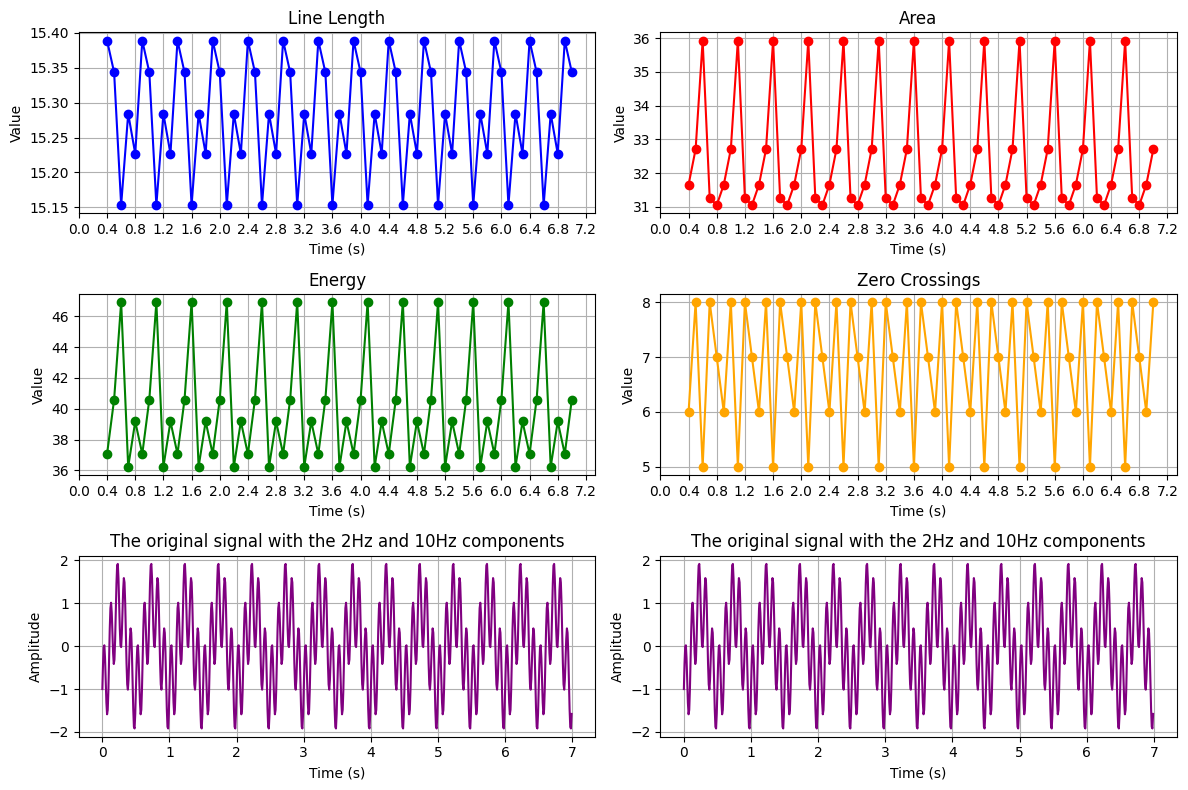

In [55]:
# My code here
# Define the signal function

# Define feature functions
winDisp_sec_4d = 100 / 10**3

Update_LineLength = MovingWinFeats(update_sine_array, sample_freq, winLen_sec, winDisp_sec_4d, line_length)
# print(Update_LineLength)
Update_Area = MovingWinFeats(update_sine_array, sample_freq, winLen_sec, winDisp_sec_4d, Area)
# print(Update_Area)
Update_Energy = MovingWinFeats(update_sine_array, sample_freq, winLen_sec, winDisp_sec_4d, Energy)
Update_ZeroCrossings = MovingWinFeats(update_sine_array, sample_freq, winLen_sec, winDisp_sec_4d, Zero_Crossings)

# print(len(time))
#time_range1 = np.arange(winLen_sec, duration + winDisp_sec_4d, winDisp_sec_4d)
#time_range2 = np.arange(winLen_sec, duration + winLen_sec, winDisp_sec_4d)
#time_range3 = np.arange(winLen_sec, duration + winLen_sec, winDisp_sec_4d)
#time_range4 = np.arange(winLen_sec, duration + winLen_sec, winDisp_sec_4d)
overall_time_range = np.arange(0.4, 7.1, 0.1)


# Plot the values of the four features
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Plot Line Length
axs[0, 0].plot(overall_time_range, Update_LineLength, '-o', color='b')
### Using the right-aligned convention
axs[0, 0].set_xticks(np.arange(0, duration + winLen_sec, step=0.4))
axs[0, 0].set_title('Line Length')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Value')
axs[0, 0].grid(True)

# Plot Area
axs[0, 1].plot(overall_time_range, Update_Area, '-o', color='r')
### Using the right-aligned convention
axs[0, 1].set_xticks(np.arange(0, duration + winLen_sec, step=0.4))
axs[0, 1].set_title('Area')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Value')
axs[0, 1].grid(True)

# Plot Mean
axs[1, 0].plot(overall_time_range, Update_Energy, '-o', color='g')
### Using the right-aligned convention
axs[1, 0].set_xticks(np.arange(0, duration + winLen_sec, step=0.4))
axs[1, 0].set_title('Energy')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Value')
axs[1, 0].grid(True)

# Plot Zero Crossings
axs[1, 1].plot(overall_time_range, Update_ZeroCrossings, '-o', color='orange')
### Using the right-aligned convention
axs[1, 1].set_xticks(np.arange(0, duration + winLen_sec, step=0.4))
axs[1, 1].set_title('Zero Crossings')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Value')
axs[1, 1].grid(True)

# Plot original signal
axs[2, 0].plot(time, update_sine_array, color='purple')
axs[2, 0].set_title('The original signal with the 2Hz and 10Hz components')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Amplitude')
axs[2, 0].grid(True)

# Plot the 2Hz and 10Hz components
axs[2, 1].plot(time, update_sine_array, color='purple')
axs[2, 1].set_title('The original signal with the 2Hz and 10Hz components')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Amplitude')
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()

Your answer here

## 2. Feature Overlays (17 pts)
In this section, you will use a line-length feature overlay on a segment of EEG containing a seizure. This data is stored in I521_A0003_D001.

Note that IEEG can only send so much data at once (about 600,000 datapoints per channel at a time). To help you import the longer datasets we'll be using in this homework (and in some of the future ones), we've included the following loading function. Feel free to use it.

In [56]:
def load_full_channels(dataset, duration_secs, sampling_rate, chn_idx):
  """
  Loads the entire channel from IEEG.org
  Input:
    dataset: the IEEG dataset object
    duration_secs: the duration of the channel, in seconds
    sampling_rate: the sampling rate of the channel, in Hz
    chn_idx: the indicies of the m channels you want to load, as an array-like object
  Returns:
    [n, m] ndarry of the channels' values.
  """
  #stores the segments of the channel's data
  chn_segments = []

  #how many segments do we expect?
  num_segments = int(np.ceil(duration_secs * sampling_rate / 6e5))

  #segment start times and the step
  seg_start, step = np.linspace(1, duration_secs*1e6, num_segments, endpoint=False, retstep=True)

  #get the segments
  for start in seg_start:
    chn_segments.append(dataset.get_data(start, step, chn_idx))

  #concatenate the segments vertically
  return np.vstack(chn_segments)

In [57]:
# open the binary file and use its content to create a session frmo IEEG
with open('/content/Yua_ieeglogin.bin', 'r') as f:
  session = Session('Yuanchz1118', f.read())

# get the specified dataset from IEEG
dataset = session.open_dataset('I521_A0003_D001')

label = dataset.get_channel_labels()
index = dataset.get_channel_indices(label)
timeseries = dataset.get_time_series_details(label[0])
print(timeseries, "\n")
sample_rate = timeseries.sample_rate
print("Smpling rate of this dataset:",sample_rate, "Hz", "\n")

start_time = timeseries.start_time
end_time = timeseries.end_time

dataset_duration = timeseries.duration
print("Duration of this dataset:", dataset_duration, "\n")

full_data = load_full_channels(dataset, dataset_duration / 10**6, sample_rate, index)
print("The total number of data points before clipping:", len(full_data))

None(szChirps) spans 4880390000.0 usec, range [-204300-204700] in 976079 samples. Starts @1 uUTC, ends @4880390001 uUTC with sample rate 200.0 Hz and voltage conv factor 0.01 

Smpling rate of this dataset: 200.0 Hz 

Duration of this dataset: 4880390000.0 

The total number of data points before clipping: 976078


### 1
What is the length using hrs:min:sec.ms of the recording?
You may find [`divmod`](https://docs.python.org/3/library/functions.html) to be helpful. Also, the `time` and `datetime` packages are imported and can also be used. (2 pts)

In [58]:
# My code here

# Total duration of the recording in seconds
### 1 us = 1 / 10**6 second
dataset_duration_seconds = dataset_duration / 10**6
# print(dataset_duration_seconds)
# print(int(dataset_duration_seconds))

# Convert seconds to hours, minutes, and seconds
### 1 hour = 3600 seconds
hours, remainder = divmod(dataset_duration_seconds, 3600)
### 1 min = 60 seconds
minutes, seconds = divmod(remainder, 60)

# Extract milliseconds
### 1 milliseconds = 10^3 us : 0.390 ms -> 390 us
milliseconds = (dataset_duration_seconds - int(dataset_duration_seconds)) * 10**3

# Format the result
duration_length = '{:02d}:{:02d}:{:02d}.{:03d}'.format(int(hours), int(minutes), int(seconds), int(milliseconds))

print("Length of the recording (hrs:min:sec.ms):", duration_length)

Length of the recording (hrs:min:sec.ms): 01:21:20.390


**My Answer Here:**

Length of the recording (hrs:min:sec.ms) is **01:21:20.390**

### 2
How many data points should we discard at the end if we want to clip the recording to the last full second? Do this clipping. (1 pt)

In [59]:
# My code here
remain_duration = int(dataset_duration_seconds)
# print(remain_duration)

discard_duration = dataset_duration_seconds - remain_duration
# print(discard_duration)

discard_data = load_full_channels(dataset, discard_duration, sample_rate, index)
Num_Discard = len(discard_data)
print("Number of data points we should discard:", Num_Discard)

remain_data = load_full_channels(dataset, int(dataset_duration_seconds), sample_rate, index)
# print("Number of remaining data points:", len(remain_data))

Number of data points we should discard: 78


**My Answer Here:**

**78** data points we should discard at the end if we want to clip the recording to the last full second.

### 3
If we want to overlay a feature trace on the original signal, we have to interpolate that feature (which has been calculated over windows) for each data point of the original signal. One of the simplest methods of doing this is called zero-order interpolation, where we just hold the value constant until we
get to the next calculated value. For example, if we had a moving window of 1 second with 1 second displacement, the zero-order interpolated feature vector would have the same value the entire 1s5 second, then the same for the entire 2nd second, etc, where each second contains the same number of points as the sampling frequency of the original signal.

####3a
Using the [`np.tile`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html) and [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) functions, create an external function `zoInterp(x, numInterp)` that copies each value of `x` `numInterp` times. For `np.reshape`, setting `order='F'` may be necessary. You can implement this function in one line. (2 pts)

In [60]:
# My code here

''' def zoInterp(x, numInterp): return np.reshape(np.tile(x, numInterp), -1, order='F') '''

### I feel confused with the usage of np.tile and np.reshape, thus I apply np.repeat as the alternative method with the same resulting vector
def zoInterp(x, numInterp): return np.repeat(x, numInterp)

####3b
Confirm that this function works correctly by expanding the length of the vector `[1, 2, 3, 4, 5]` by a factor of 5. Plot your results using the `-o` plotting option to let us see the individual points and the line that connects them. (2 pts)

> Hint: your resulting vector should be a column vector of [1,1,1,1,1,2,2,2,...]

My resulting vector: [1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5]


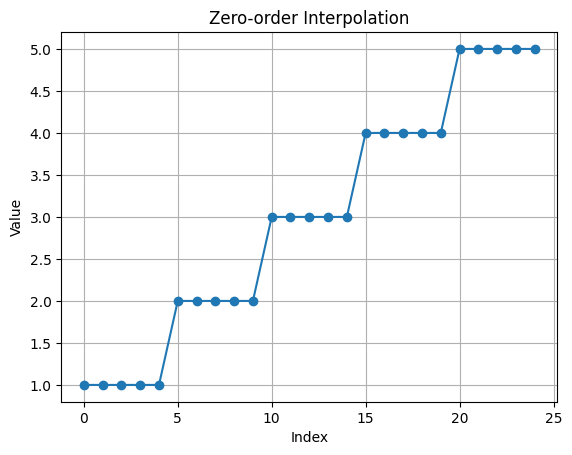

In [25]:
# My code here
vertor_3b = [1, 2, 3, 4, 5]
numInterp_3b = 5
x_interpolated = zoInterp(vertor_3b, numInterp_3b)
print("My resulting vector:", x_interpolated)
# Plot the results
plt.plot(x_interpolated, '-o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Zero-order Interpolation')
plt.grid(True)
plt.show()

### 4
Using a 5-second sliding window with 1-second displacement, calculate the line-length feature over the entire signal. Normalize the line-length feature values to have a maximum twice that of the original EEG signal maximum. Plot the signal in blue and overlay the right-aligned line-length feature in yellow.
Note: you will need to [pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) your signal in order to get them to line up correctly and be the same length. Be sure to add a legend in a location in the plot that does not cover up any signal or feature. (6 pts)

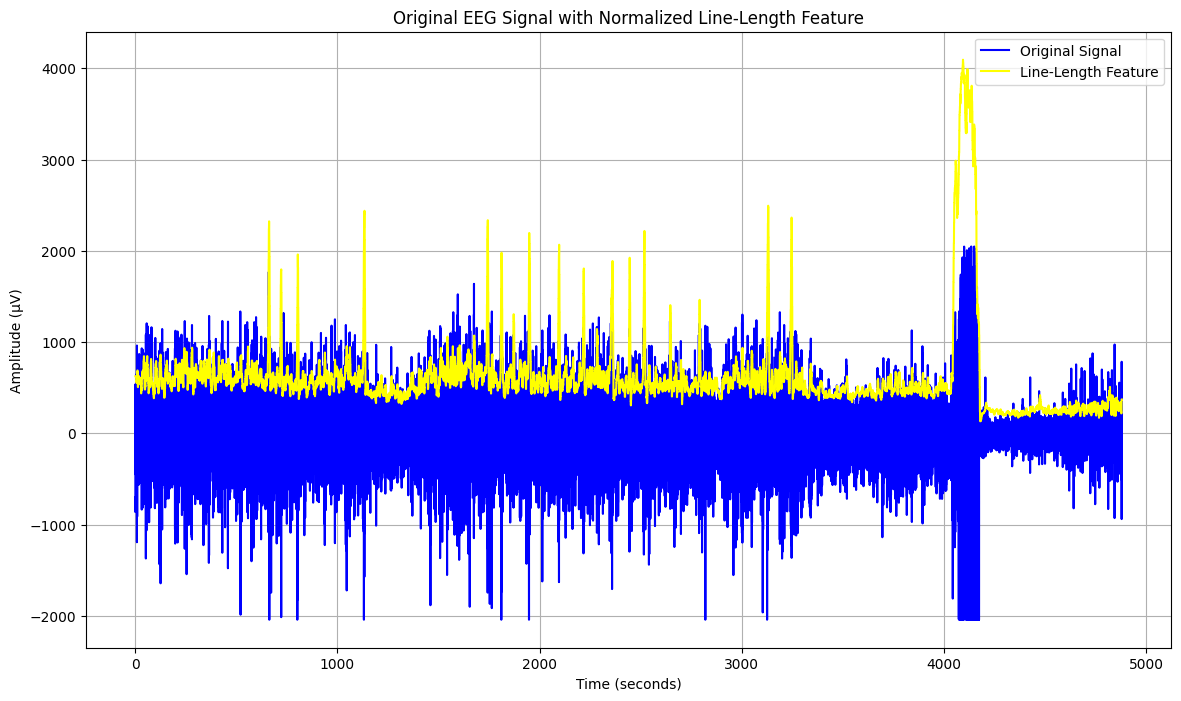

In [26]:
# My code here
winLen_sec_4 = 5
winDisp_sec_4 = 1

remain_samples = len(remain_data)

remain_egg_freq = int(remain_duration * sample_rate)
# print(remain_egg_freq)
time_array = np.linspace(0, remain_duration, remain_egg_freq, endpoint = False)
# print(time_array)
# num_windows = NumWins(remain_data, remain_samples, sample_rate, winLen_sec_4, winDisp_sec_4)

# Calculate line-length feature
Update_line_length_4 = MovingWinFeats(remain_data, sample_rate, winLen_sec_4, winDisp_sec_4, line_length)

# Normalize line-length feature
max_eeg_signal = np.max(remain_data)
# print(max_eeg_signal)
max_line_length = np.max(Update_line_length_4)

normalized_line_length = zoInterp(Update_line_length_4 / max_line_length * max_eeg_signal * 2, sample_rate)
# print(len(normalized_line_length))
# print(len(remain_data))

### Pad my signal in order to get them to line up correctly and be the same length
pad_normalized_line_length = np.pad(normalized_line_length, (len(remain_data) - len(normalized_line_length),0), 'edge')
# print(len(pad_normalized_line_length))

# Plot original signal and line-length feature
plt.figure(figsize=(14, 8))
plt.plot(time_array, remain_data, color='blue', label='Original Signal')
#plt.plot(time_array[-len(normalized_line_length):], normalized_line_length, color='yellow', label='Line-Length Feature')
plt.plot(time_array, pad_normalized_line_length, color='yellow', label='Line-Length Feature')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original EEG Signal with Normalized Line-Length Feature')
plt.legend()
plt.grid(True)
plt.show()

Your answer here

### 5
What threshold might you use on the raw line-length feature vector (not the normalized one used for plotting) in order to capture the 17 largest pre-seizure chirps that occur? (1 pt)

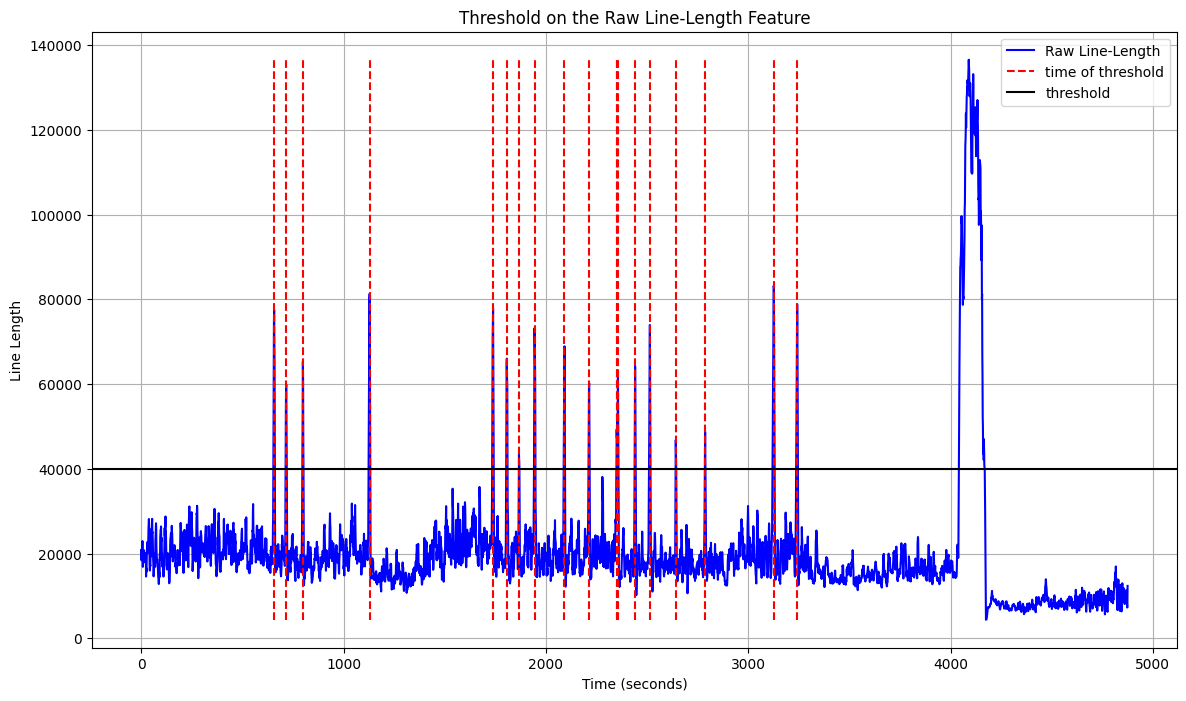

In [27]:
t = 0
threshold = 40000
min_y = np.min(remain_data)
max_y = np.max(pad_normalized_line_length)

ll_threshold_list = []
time_threshold_list = []

for t in range(len(Update_line_length_4) - 1000):
  if Update_line_length_4[t] > threshold and Update_line_length_4[t] < 90000 and Update_line_length_4[t - 1] < Update_line_length_4[t] and Update_line_length_4[t + 1] < Update_line_length_4[t]:
    time_threshold_list.append(t)
    ll_threshold_list.append(Update_line_length_4[t])

# print(time_threshold_list)
# print(ll_threshold_list)

plt.figure(figsize=(14, 8))
plt.xlabel('Time (seconds)')
plt.ylabel('Line Length')
plt.plot(Update_line_length_4, color='blue', label = 'Raw Line-Length')
# plt.scatter(time_threshold_list, ll_threshold_list, marker = 'x', color = 'r')

### Red dashed line represents time of threshold, Black line represents value of threshold before normalization
plt.vlines(time_threshold_list, min(Update_line_length_4), max(Update_line_length_4), color = 'red', label = 'time of threshold', linestyle='dashed')
plt.axhline(threshold, color = 'black', label = 'threshold')
plt.title('Threshold on the Raw Line-Length Feature')
plt.legend()
plt.grid(True)
plt.show()

**My Answer Here:**

Threshold I use on the raw line-length feature vector: **40000**

### 6
Using this threshold value, in another plot draw red [vertical](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.vlines.html#matplotlib.pyplot.vlines) dashed lines at the leading point in time where the threshold is crossed. Add these vertical lines on top of the plot you made in Question 2.4. These events should capture the pre-seizure chirps, the seizure onset, and some flickering during the end of the seizure. (3 pts)

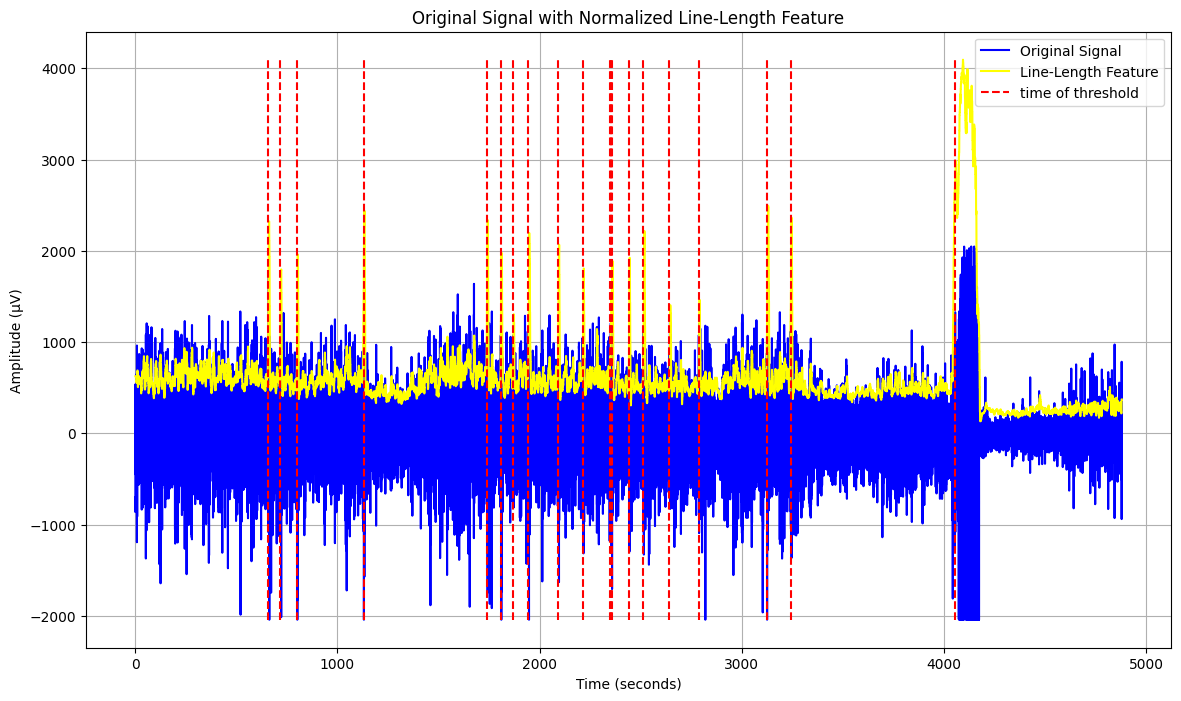

In [28]:
# My code here
t2 = 0
t3 = 0
ll_threshold_list2 = []
time_threshold_list2 = []

for t2 in range(len(Update_line_length_4) - 1000):
  if Update_line_length_4[t2] > threshold and Update_line_length_4[t2] < 90000 and Update_line_length_4[t2 - 1] < Update_line_length_4[t2] and Update_line_length_4[t2 + 1] < Update_line_length_4[t2]:
    time_threshold_list2.append(t2)
    ll_threshold_list2.append(Update_line_length_4[t2])

for t3 in range(len(Update_line_length_4) - 999, len(Update_line_length_4)):
  if Update_line_length_4[t3] > threshold and Update_line_length_4[t3 - 1] < Update_line_length_4[t3] and Update_line_length_4[t3 + 1] < Update_line_length_4[t3]:
    time_threshold_list2.append(t3)
    ll_threshold_list2.append(Update_line_length_4[t3])
    break

# print(time_threshold_list2)
# print(ll_threshold_list2)

# Plot original signal and line-length feature
plt.figure(figsize=(14, 8))
plt.plot(time_array, remain_data, color='blue', label='Original Signal')
plt.plot(time_array, pad_normalized_line_length, color='yellow', label='Line-Length Feature')
#plt.scatter(time_threshold_list, ll_threshold_list, marker = 'x', color = 'r')
plt.vlines(time_threshold_list2, min_y, max_y, color = 'red', label = 'time of threshold', linestyle='dashed')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal with Normalized Line-Length Feature')
plt.legend()
plt.grid(True)
plt.show()

Your answer here

## 3. Building a Detector (12 pts)

In this section, you will use the features you defined previously to build a seizure detector. Use the EEG data in the file I521_A0003_D002 with channels multiSz_1, and multiSz_2.

In [29]:
# get the specified dataset from IEEG
dataset2 = session.open_dataset('I521_A0003_D002')

label2 = dataset2.get_channel_labels()
index2 = dataset2.get_channel_indices(label2)

### channel multiSz_1
timeseries2_multiSz_1 = dataset2.get_time_series_details(label2[0])
print(timeseries2_multiSz_1, "\n")

sample_rate2_multiSz_1 = timeseries2_multiSz_1.sample_rate
print("Smpling rate of this dataset:",sample_rate2_multiSz_1, "Hz", "\n")

start_time2_multiSz_1 = timeseries2_multiSz_1.start_time / 10**6
end_time2_multiSz_1 = timeseries2_multiSz_1.end_time / 10**6

dataset_duration2_multiSz_1 = timeseries2_multiSz_1.duration / 10**6
print("Duration of this dataset:", dataset_duration2_multiSz_1, "seconds\n")

full_data2_multiSz_1 = load_full_channels(dataset2, dataset_duration2_multiSz_1, sample_rate2_multiSz_1, [0])
print("The total number of data points before clipping:", len(full_data2_multiSz_1), "\n\n")

### channel multiSz_2
timeseries2_multiSz_2 = dataset2.get_time_series_details(label2[1])
print(timeseries2_multiSz_2, "\n")

sample_rate2_multiSz_2 = timeseries2_multiSz_2.sample_rate
print("Smpling rate of this dataset:",sample_rate2_multiSz_2, "Hz", "\n")

start_time2_multiSz_2 = timeseries2_multiSz_2.start_time / 10**6
end_time2_multiSz_2 = timeseries2_multiSz_2.end_time /10**6

dataset_duration2_multiSz_2 = timeseries2_multiSz_2.duration / 10**6
print("Duration of this dataset:", dataset_duration2_multiSz_2, "seconds \n")

full_data2_multiSz_2 = load_full_channels(dataset2, dataset_duration2_multiSz_2, sample_rate2_multiSz_2, [1])
print("The total number of data points before clipping:", len(full_data2_multiSz_2))

None(multiSz_1) spans 14999995000.0 usec, range [-197400-247000] in 3000000 samples. Starts @1 uUTC, ends @14999995001 uUTC with sample rate 200.0 Hz and voltage conv factor 0.01 

Smpling rate of this dataset: 200.0 Hz 

Duration of this dataset: 14999.995 seconds

The total number of data points before clipping: 3000000 


None(multiSz_2) spans 13474995000.0 usec, range [-168300-202100] in 2695000 samples. Starts @1 uUTC, ends @13474995001 uUTC with sample rate 200.0 Hz and voltage conv factor 0.01 

Smpling rate of this dataset: 200.0 Hz 

Duration of this dataset: 13474.995 seconds 

The total number of data points before clipping: 2695000


### 1
Plot the signal in multiSz_1 and draw vertical dashed red lines at the times when you think the two seizures begin. You should be able to do this without the need of any features. (2 pts)

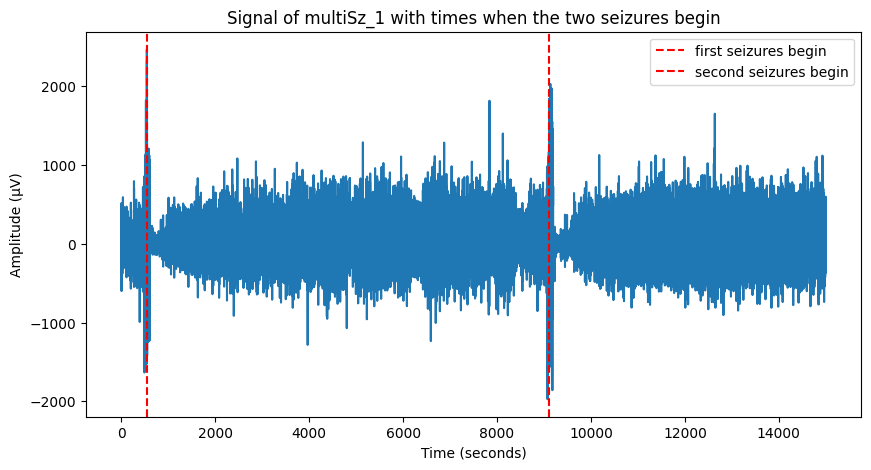

In [30]:
# My code here
time_range_multiSz_1 = np.arange(start_time2_multiSz_1, start_time2_multiSz_1 + dataset_duration2_multiSz_1, dataset_duration2_multiSz_1 / len(full_data2_multiSz_1))
# print(max(full_data2_multiSz_1))

tmp_full_data2_multiSz_1 = full_data2_multiSz_1.flatten()
multiSz_1_threshold_index2 = np.argsort(tmp_full_data2_multiSz_1)[-2]  # Get the index of the 17th largest value
# print(multiSz_1_threshold_index2)
multiSz_1_threshold_value2 = time_range_multiSz_1[multiSz_1_threshold_index2]
# print(threshold_value2)

multiSz_1_threshold_index3 = np.argsort(tmp_full_data2_multiSz_1)[-1000]
# print(multiSz_1_threshold_index3)
multiSz_1_threshold_value3 = time_range_multiSz_1[multiSz_1_threshold_index3]
# print(multiSz_1_threshold_value3)

plt.figure(figsize = (10, 5))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.plot(time_range_multiSz_1, full_data2_multiSz_1)
plt.axvline(multiSz_1_threshold_value2, color = 'red', label = 'first seizures begin', linestyle='dashed')
plt.axvline(multiSz_1_threshold_value3, color = 'red', label = 'second seizures begin', linestyle='dashed')
plt.title('Signal of multiSz_1 with times when the two seizures begin')
plt.legend(loc='upper right')
plt.show()

Your answer here

### 2
Produce feature overlay plots similar to that of Question 2.4 for each of the four features you have implemented along with the red vertical dashed lines at each seizure. Use a 4-second sliding window with 1 second displacement. (4 pts)

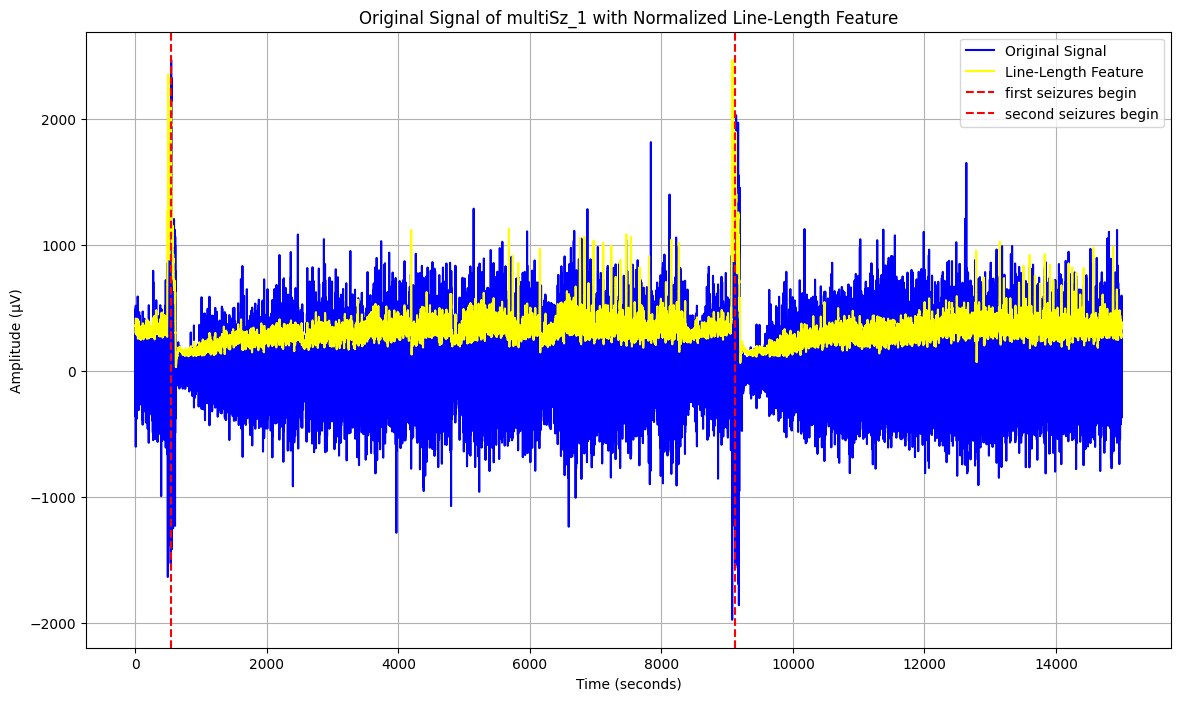

In [31]:
# My code here
# print(full_data2_multiSz_1.shape)
winLen_sec_multiSz_1 = 4
winDisp_sec_multiSz_1 = 1

remain_multiSz_1_samples = len(full_data2_multiSz_1)

remain_multiSz_1_freq = int((round(dataset_duration2_multiSz_1) * sample_rate2_multiSz_1))
# print(remain_multiSz_1_freq)
multiSz_1_time_array = np.linspace(0, dataset_duration2_multiSz_1, remain_multiSz_1_freq, endpoint = False)
# print(multiSz_1_time_array)

# Calculate line-length feature
line_length_multiSz_1 = MovingWinFeats(full_data2_multiSz_1, sample_rate2_multiSz_1, winLen_sec_multiSz_1, winDisp_sec_multiSz_1, line_length)

# Normalize line-length feature
max_multiSz_1_signal = np.max(full_data2_multiSz_1)
# print(max_multiSz_1_signal)
ll_max_multiSz_1 = np.max(line_length_multiSz_1)

ll_normalized_multiSz_1= zoInterp(line_length_multiSz_1 / ll_max_multiSz_1 * max_multiSz_1_signal, sample_rate2_multiSz_1)
# print(len(ll_normalized_multiSz_1))

### Pad my signal in order to get them to line up correctly and be the same length
ll_multiSz_1_pad_normalized = np.pad(ll_normalized_multiSz_1, (len(full_data2_multiSz_1) - len(ll_normalized_multiSz_1),0), 'edge')
# print(len(ll_multiSz_1_pad_normalized))

# Plot original signal and line-length feature
plt.figure(figsize=(14, 8))
plt.plot(multiSz_1_time_array, full_data2_multiSz_1, color='blue', label='Original Signal')
plt.plot(multiSz_1_time_array, ll_multiSz_1_pad_normalized, color='yellow', label='Line-Length Feature')
plt.axvline(multiSz_1_threshold_value2, color = 'red', label = 'first seizures begin', linestyle='dashed')
plt.axvline(multiSz_1_threshold_value3, color = 'red', label = 'second seizures begin', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal of multiSz_1 with Normalized Line-Length Feature')
plt.legend()
plt.grid(True)
plt.show()

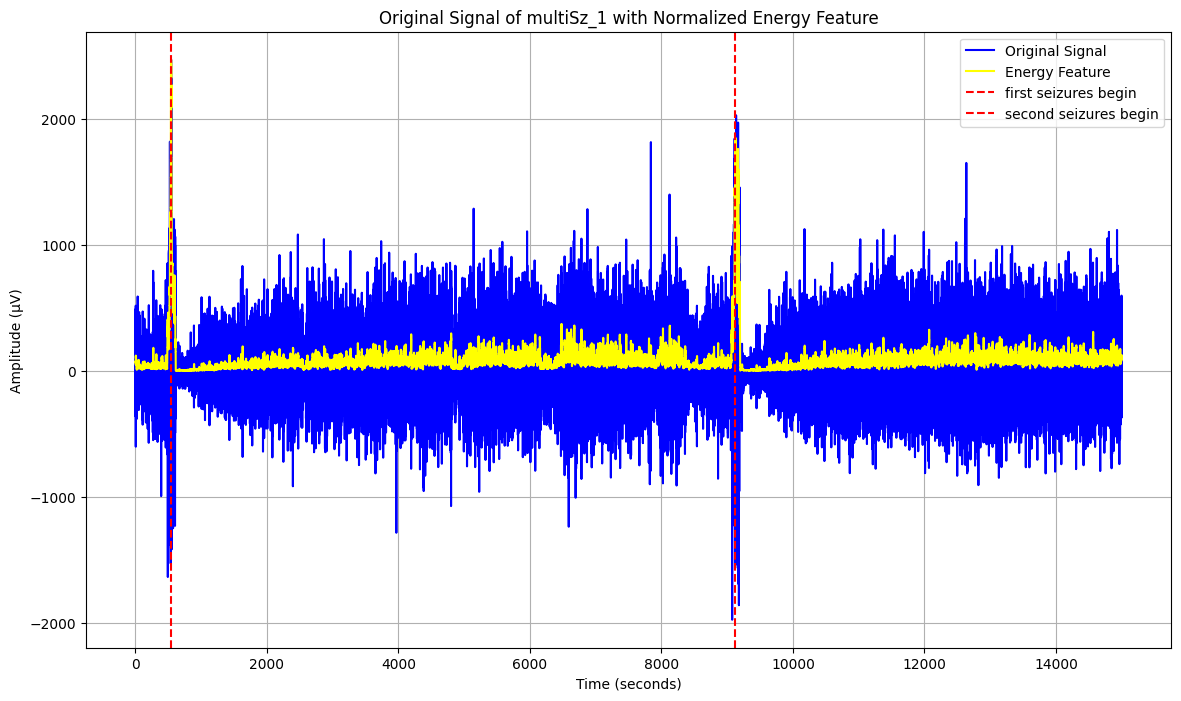

In [32]:
# Calculate Energy feature
energy_multiSz_1 = MovingWinFeats(full_data2_multiSz_1, sample_rate2_multiSz_1, winLen_sec_multiSz_1, winDisp_sec_multiSz_1, Energy)

# Normalize Energy feature
max_multiSz_1_signal = np.max(full_data2_multiSz_1)
energy_max_multiSz_1 = np.max(energy_multiSz_1)
energy_normalized_multiSz_1 = zoInterp(energy_multiSz_1 / energy_max_multiSz_1 * max_multiSz_1_signal, sample_rate2_multiSz_1)

### Pad my signal in order to get them to line up correctly and be the same length
energy_multiSz_1_pad_normalized = np.pad(energy_normalized_multiSz_1, (len(full_data2_multiSz_1) - len(energy_normalized_multiSz_1),0), 'edge')

# Plot original signal and Energy feature
plt.figure(figsize=(14, 8))
plt.plot(multiSz_1_time_array, full_data2_multiSz_1, color='blue', label='Original Signal')
plt.plot(multiSz_1_time_array, energy_multiSz_1_pad_normalized, color='yellow', label='Energy Feature')
plt.axvline(multiSz_1_threshold_value2, color = 'red', label = 'first seizures begin', linestyle='dashed')
plt.axvline(multiSz_1_threshold_value3, color = 'red', label = 'second seizures begin', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal of multiSz_1 with Normalized Energy Feature')
plt.legend()
plt.grid(True)
plt.show()

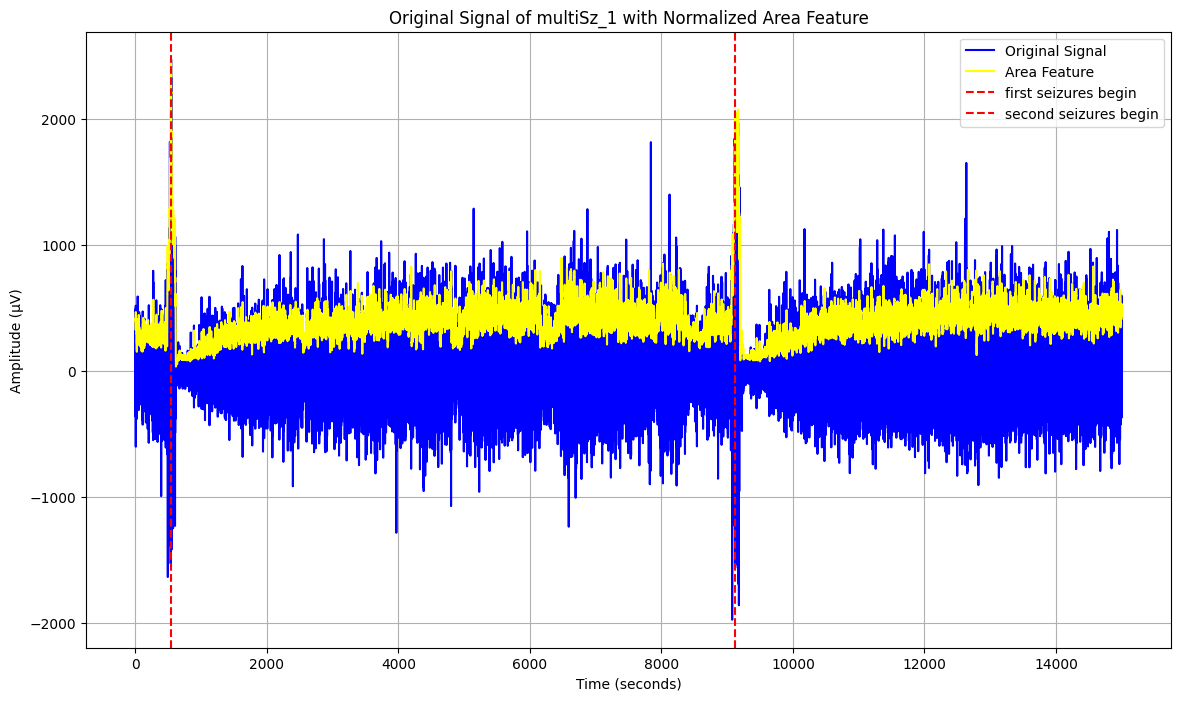

In [33]:
# Calculate Area feature
area_multiSz_1 = MovingWinFeats(full_data2_multiSz_1, sample_rate2_multiSz_1, winLen_sec_multiSz_1, winDisp_sec_multiSz_1, Area)

# Normalize Area feature
max_multiSz_1_signal = np.max(full_data2_multiSz_1)
area_max_multiSz_1 = np.max(area_multiSz_1)
area_normalized_multiSz_1= zoInterp(area_multiSz_1 / area_max_multiSz_1 * max_multiSz_1_signal, sample_rate2_multiSz_1)

### Pad my signal in order to get them to line up correctly and be the same length
area_multiSz_1_pad_normalized = np.pad(area_normalized_multiSz_1, (len(full_data2_multiSz_1) - len(area_normalized_multiSz_1),0), 'edge')

# Plot original signal and Area feature
plt.figure(figsize=(14, 8))
plt.plot(multiSz_1_time_array, full_data2_multiSz_1, color='blue', label='Original Signal')
plt.plot(multiSz_1_time_array, area_multiSz_1_pad_normalized, color='yellow', label='Area Feature')
plt.axvline(multiSz_1_threshold_value2, color = 'red', label = 'first seizures begin', linestyle='dashed')
plt.axvline(multiSz_1_threshold_value3, color = 'red', label = 'second seizures begin', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal of multiSz_1 with Normalized Area Feature')
plt.legend()
plt.grid(True)
plt.show()

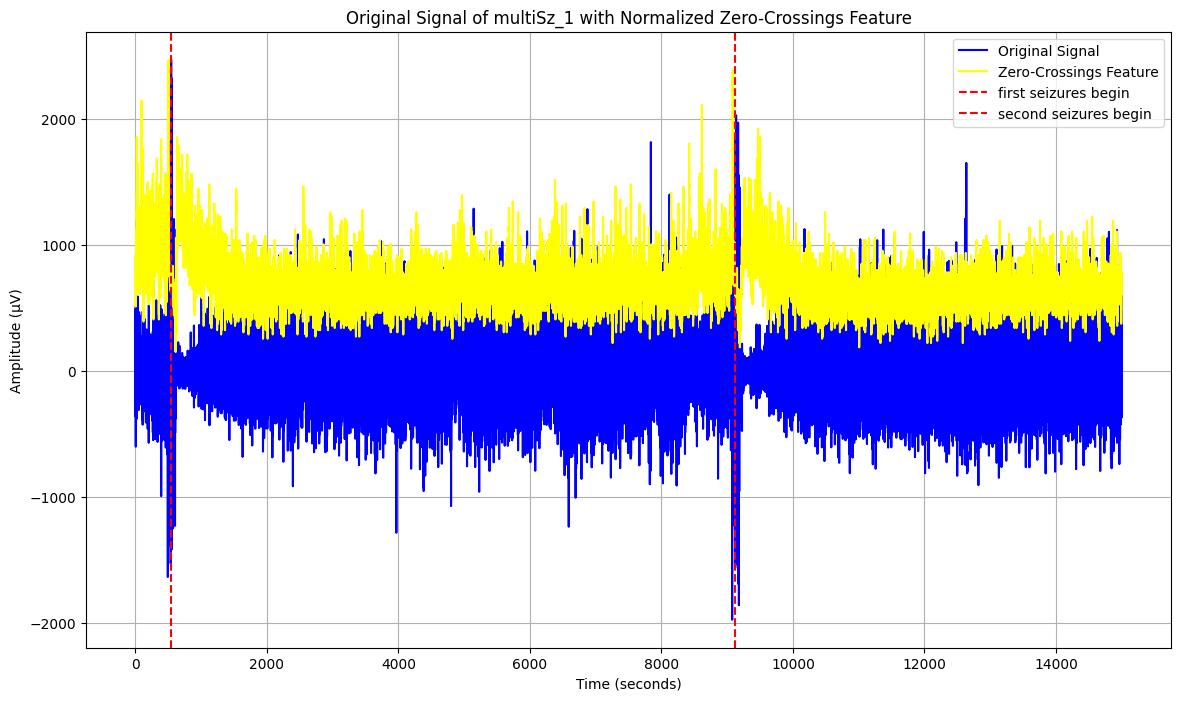

In [34]:
# Calculate Area feature
ZC_multiSz_1 = MovingWinFeats(full_data2_multiSz_1, sample_rate2_multiSz_1, winLen_sec_multiSz_1, winDisp_sec_multiSz_1, Zero_Crossings)

# Normalize Zero-Crossings feature
max_multiSz_1_signal = np.max(full_data2_multiSz_1)
ZC_max_multiSz_1 = np.max(ZC_multiSz_1)
ZC_normalized_multiSz_1= zoInterp(ZC_multiSz_1 / ZC_max_multiSz_1 * max_multiSz_1_signal, sample_rate2_multiSz_1)

### Pad my signal in order to get them to line up correctly and be the same length
ZC_multiSz_1_pad_normalized = np.pad(ZC_normalized_multiSz_1, (len(full_data2_multiSz_1) - len(ZC_normalized_multiSz_1),0), 'edge')

# Plot original signal and Zero-Crossings feature
plt.figure(figsize=(14, 8))
plt.plot(multiSz_1_time_array, full_data2_multiSz_1, color='blue', label='Original Signal')
plt.plot(multiSz_1_time_array, ZC_multiSz_1_pad_normalized, color='yellow', label='Zero-Crossings Feature')
plt.axvline(multiSz_1_threshold_value2, color = 'red', label = 'first seizures begin', linestyle='dashed')
plt.axvline(multiSz_1_threshold_value3, color = 'red', label = 'second seizures begin', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal of multiSz_1 with Normalized Zero-Crossings Feature')
plt.legend()
plt.grid(True)
plt.show()

### 3

####3a
Based on your plots in the previous question, which of the four features seems to give the largest signal (relative to the background) for when a  seizure occurs? Explain why you think this feature is the best. (3 pts)

**My Answer Here:**

**The Energy Feature** seems to give the largest signal (relative to the background) when a seizure occurs.

In EEG (electroencephalography) recordings, the threshold refers to abnormal electrical activity in the brain indicative of a seizure. For example, two dashed red lines in the multiSz_1 represent abnormal electrical activities with two of the most extraordinary spikes with much larger amplitudes than other data. Thus, we can choose a feature with **two relatively more apparent spikes** to determine the threshold at the start of a seizure.

Based on the four plots in the previous question, the original signal with **The Energy Feature** should give the most significant signal for Seizure Occurrences because two spikes in this feature should be much more distinguishable than any other three features, which facilitates and improves efficiencies of Seizure Occurences Detection.

####3b
What threshold would you use to determine if a seizure is occurring? (1 pt)

**My Answer Here:**

In EEG (electroencephalography) recordings, the threshold refers to abnormal electrical activity in the brain indicative of a seizure. For example, two dashed red lines in the multiSz_1 represent abnormal electrical activities with two of the most extraordinary spikes with much larger amplitudes than other data. Thus, we can choose two relatively more apparent thresholds to determine the threshold at the start of a seizure.

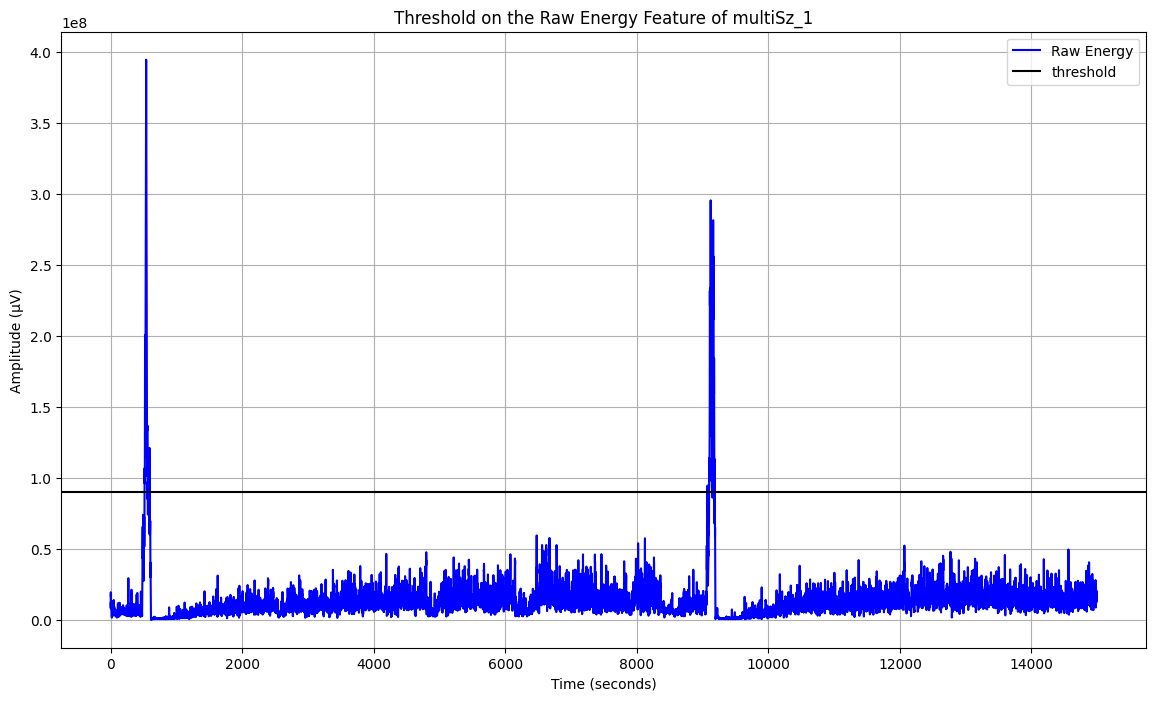

In [35]:
# My code here
multiSz_1_threshold = 0.9 * 10**8

# print(time_threshold_list)
# print(ll_threshold_list)

# Plot original signal and line-length feature
plt.figure(figsize=(14, 8))
plt.plot(energy_multiSz_1, color='blue', label='Raw Energy')
#plt.vlines(time_threshold_list, min(Update_line_length_4), max(Update_line_length_4), color = 'red', label = 'time of threshold', linestyle='dashed')
plt.axhline(multiSz_1_threshold, color = 'black', label = 'threshold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Threshold on the Raw Energy Feature of multiSz_1')
plt.legend()
plt.grid(True)
plt.show()

**My Answer Here:**

Because I choose Energy feature, depending on the plot of Raw Energy above, I would use **90000000** as threshold to determine if a seizure is occurring, horizontal black line represents my chosen threshold.

### 4
The signal in multiSz_2 contains another seizure (whose location should again be fairly obvious). Plot the data along with the feature and threshold (horizontal black line, with correct normalization for the signal in data2) you determined in the previous question. (2 pts)

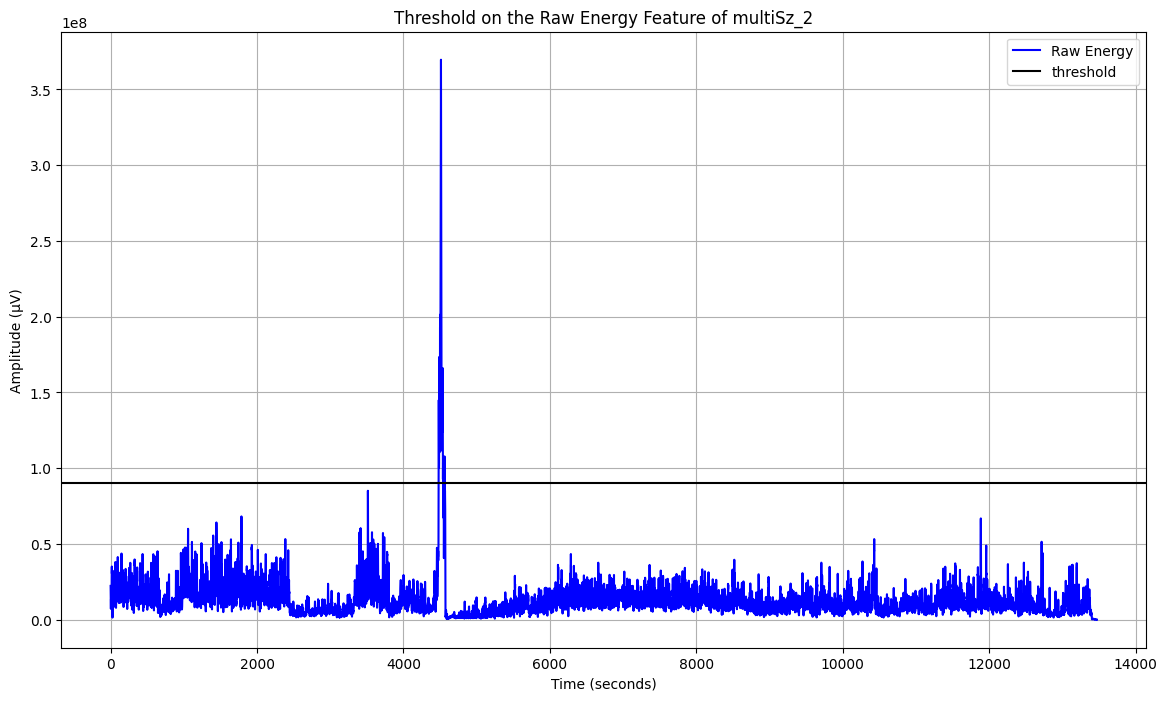

In [61]:
# Calculate Energy feature
multiSz_2_threshold = multiSz_1_threshold

energy_multiSz_2 = MovingWinFeats(full_data2_multiSz_2, sample_rate2_multiSz_2, winLen_sec_multiSz_1, winDisp_sec_multiSz_1, Energy)
plt.figure(figsize=(14, 8))
plt.plot(energy_multiSz_2, color='blue', label='Raw Energy')
plt.axhline(multiSz_2_threshold, color = 'black', label = 'threshold')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Threshold on the Raw Energy Feature of multiSz_2')
plt.legend()
plt.grid(True)
plt.show()

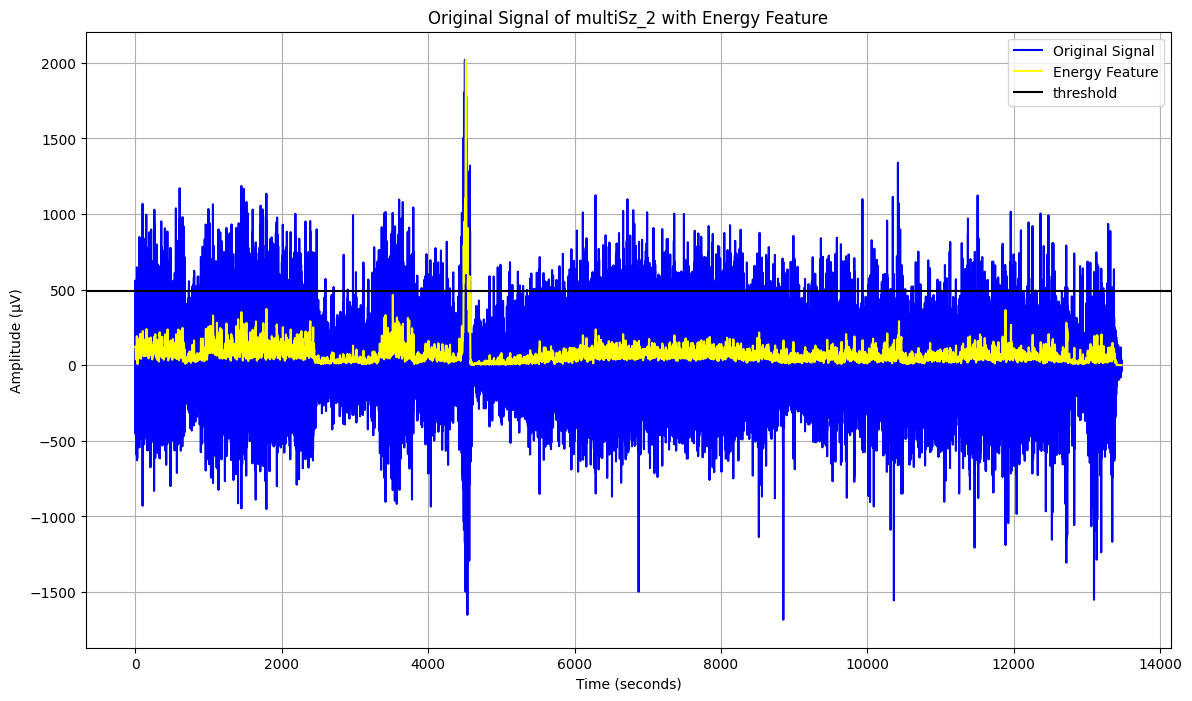

In [63]:
# My code here
remain_multiSz_2_samples = len(full_data2_multiSz_2)
remain_multiSz_2_freq = int((round(dataset_duration2_multiSz_2) * sample_rate2_multiSz_2))
multiSz_2_time_array = np.linspace(0, dataset_duration2_multiSz_2, remain_multiSz_2_freq, endpoint = False)

# Normalize Energy feature
max_multiSz_2_signal = np.max(full_data2_multiSz_2)
energy_max_multiSz_2 = np.max(energy_multiSz_2)
energy_normalized_multiSz_2 = zoInterp(energy_multiSz_2 / energy_max_multiSz_2 * max_multiSz_2_signal, sample_rate2_multiSz_2)

### Pad my signal in order to get them to line up correctly and be the same length
energy_multiSz_2_pad_normalized = np.pad(energy_normalized_multiSz_2, (len(full_data2_multiSz_2) - len(energy_normalized_multiSz_2),0), 'edge')
threshold_ratio = energy_multiSz_2_pad_normalized[0] / energy_multiSz_2[0]
# print(threshold_ratio)
normalize_multiSz_2_threshold = threshold_ratio * multiSz_2_threshold
# print(normalize_multiSz_2_threshold)

# Plot original signal and Energy feature
plt.figure(figsize=(14, 8))
plt.plot(multiSz_2_time_array , full_data2_multiSz_2, color='blue', label='Original Signal')
plt.plot(multiSz_2_time_array, energy_multiSz_2_pad_normalized, color='yellow', label='Energy Feature')
plt.axhline(normalize_multiSz_2_threshold, color = 'black', label = 'threshold')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('Original Signal of multiSz_2 with Energy Feature')
plt.legend()
plt.grid(True)
plt.show()